NEEDED
- reference (here Salmo salar)

PROGRAMS
- bowtie2
- pysam


## External reference

In [9]:
import pysam
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [10]:
salmo_FASTA = '/home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta'

build bowtie2 index
 - printed because this take ~2 hours to run

In [11]:
print('bowtie2-build {} salmo'.format(salmo_FASTA))

bowtie2-build /home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta salmo


## internal reference

In [12]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

## Align

In [46]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.SAM'

In [14]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM


## Examine alignments

### Reference genome (Salmo salar)

In [15]:
ref = pysam.FastaFile(salmo_FASTA)

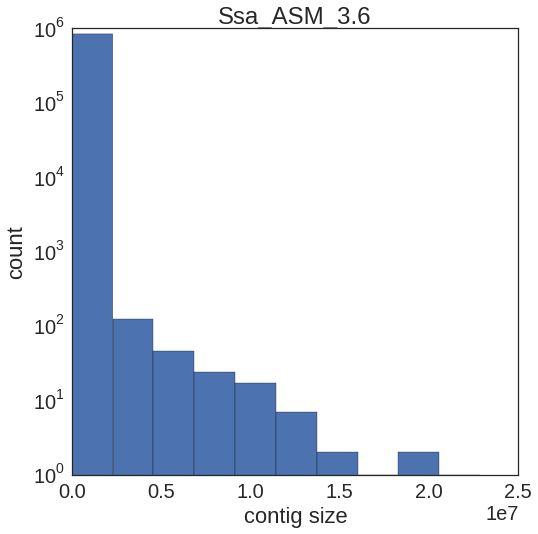

In [16]:
figsize(8,8)
plt.hist([ln for ln in ref.lengths])
plt.yscale('log', basey=10)
plt.ylabel('count')
plt.xlabel('contig size')
plt.title('Ssa_ASM_3.6')
plt.show()

#### Alignments to salmo

    

In [17]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

In [18]:
mpqs = [read.mapping_quality for read in get_aligns()]

Looks like we have three types of alignments (tri-modal)
    - spurious (MQ < 2)
    - moderate support (10 < MQ < 28)
    - strong support (MQ > 30)

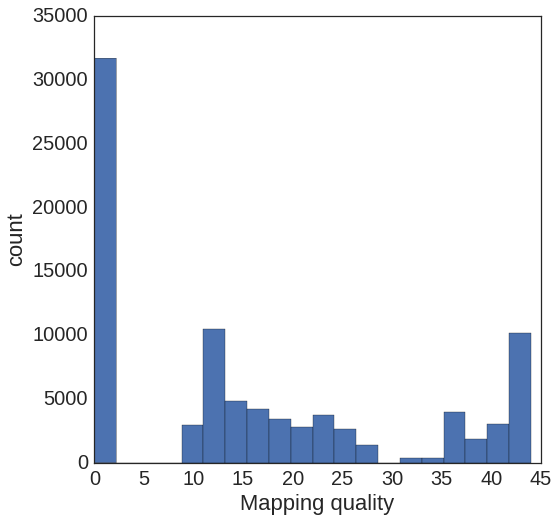

In [19]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

In [20]:
flags  = [read.flag for read in get_aligns()]

#### Flags 
* 4 = unmapped
* 16 = mapped to reverse strand

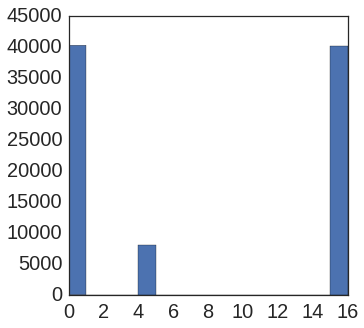

In [21]:
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

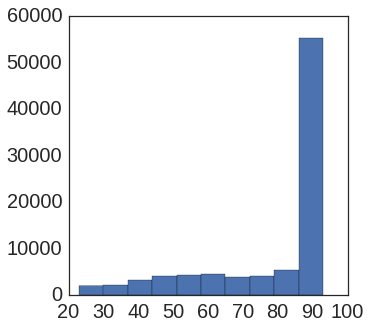

In [22]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

#### Distribution of edit distances
held by tag 'XM'

In [23]:
edit_ditances = list()
mq = list()
for read in get_aligns():
    try:
        edit_ditances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

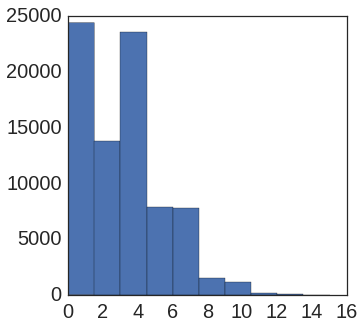

In [24]:
plt.hist(edit_ditances)
plt.show()

Edit distance does not tell the whole story. 
Low edit distances (<5) result in a braod range of mapping qualities.

In [25]:
rr = pd.DataFrame({'ed' : edit_ditances, 'mq' : mq })

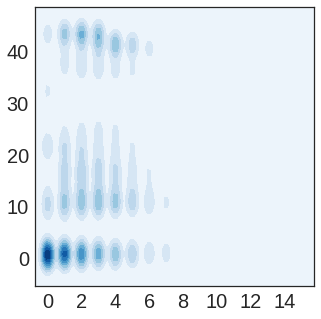

In [26]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length == 93) AND (mapping_quality >= 30)

In [47]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

Which contigs are getting alignments?

#### convert SAM to BAM, sort and index BAM

In [48]:
BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.BAM'
sorted_BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.sorted.BAM'

In [49]:
!samtools view -bh {filtered_SAM_output} > {BAM_output}
!samtools sort -O bam -T temp {BAM_output} > {sorted_BAM_output}
!samtools index  {sorted_BAM_output}

In [50]:
!samtools idxstats {sorted_BAM_output} > \
'/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage'

In [51]:
cov = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage',
           sep = "\t", header = None)
cov.columns = ['contig', 'len', 'COV', 'UNK']
cov.head()

,contig,len,COV,UNK
0,ccf1000001392_0-0,45142,0,0
1,ccf1000000113_0-0,1375438,2,0
2,ccf1000001220_0-0,71750,0,0
3,ccf1000001280_0-0,62617,0,0
4,ccf1000000663_0-0,188506,0,0


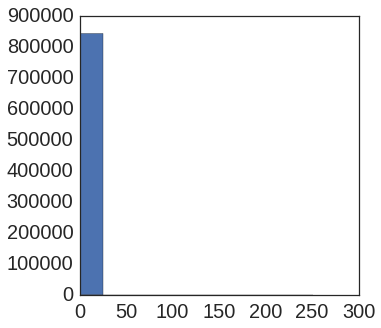

In [53]:
plt.hist(cov['COV'])

plt.show()

In [201]:
filtered_SAM = pd.read_csv(filtered_SAM_output, sep = '\t', comment='@', engine='python', 
            names = ['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','ISIZE','SEQ','QUAL',
                     'TAG1', 'TAG2', 'TAG3' 'TAG4', 'TAG5', 'TAG6', 'TAG7','TAG8', 'TAG9','TAG10'])
filtered_SAM.head()

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,ISIZE,SEQ,QUAL,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c3,0,jcf1000092099_0-0,10553614,42,93M,*,0,0,TGCAGGATTCATAGGAGAAAAACAAGGCTTCATGTCAGTTTGACCC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:154,XN:i:0,XM:i:4,XO:i:0,XG:i:0,NM:i:4,MD:Z:8G11C6G9A55,YT:Z:UU,None
1,c6,16,ccf1000000032_0-0,4350808,41,93M,*,0,0,AGTAACTTCACGGCCTCCTCCCCAGGGCTCGTTCAACTTCCAGGGC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:138,XN:i:0,XM:i:6,XO:i:0,XG:i:0,NM:i:6,MD:Z:12C16T5T4T0G9G41,YT:Z:UU,None
2,c9,0,jcf1000020280_0-0,135823,42,63M1D30M,*,0,0,TGCAGGAAACTGGGGAAATTATTTTCAACACCTTGTGATTAGTCCA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:146,XN:i:0,XM:i:4,XO:i:1,XG:i:1,NM:i:5,MD:Z:10C3A10G37^G8G21,YT:Z:UU,None
3,c10,16,jcf1001213740_0-0,1121507,44,93M,*,0,0,TGAACGCGCTGTGAACTCCAGAGATGCCCTCGCCAAGCAGATCTAT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:6G9G64T11,YT:Z:UU,None
4,c28,0,jcf1000298869_0-0,2793545,44,93M,*,0,0,TGCAGGCAAAGATGAAAAATAACACTACCACTACTGCTCAGTGTCT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:27G24A8T31,YT:Z:UU,None


In [202]:
filtered_aligns = filtered_SAM[['QNAME','RNAME', 'POS']]
filtered_aligns.head()

,QNAME,RNAME,POS
0,c3,jcf1000092099_0-0,10553614
1,c6,ccf1000000032_0-0,4350808
2,c9,jcf1000020280_0-0,135823
3,c10,jcf1001213740_0-0,1121507
4,c28,jcf1000298869_0-0,2793545


In [203]:
lep_v_pop = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/lep_v_pop.txt', sep = '\t')
lep_v_pop.head()

,stacks_SNP,contig,LEP_LG
0,7_74,c1000,11
1,7_92,c1000,11
2,68651_80,c10001,10
3,68651_91,c10001,10
4,2_78,c10003,19


In [207]:
chum_LGs = pd.merge(lep_v_pop, filtered_aligns, left_on = 'contig', right_on ='QNAME')
chum_LGs.drop_duplicates(subset=['contig'], inplace=True)
chum_LGs.head()

,stacks_SNP,contig,LEP_LG,QNAME,RNAME,POS
0,9_33,c10012,2,c10012,jcf1000929570_0-0,270508
1,70_79,c10094,26,c10094,ccf1000001122_0-0,46457
2,88_8,c10114,10,c10114,jcf1000375450_0-0,2545700
5,103_38,c1012,10,c1012,jcf1000166975_0-227626,114654
8,158_73,c1018,7,c1018,ccf1000000042_0-0,3681272


#### ots_salmo.txt is a file that lists the chromosome assignment for a small subset of the scaffolds

In [208]:
ots_salmo = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/ots_salmo.txt', 
            sep = '\t', header = 0)
ots_salmo.head()

,Linkage Group,Ssa Genome Scaffold,Map Start (cM),Map End (cM),Scaffold Start (bp),Scaffold End (bp),Map Distance (bp),Scaffold Distance (bp),bp/cM,Loci Aligned,Orientation,Ssa Chromosomal Assignment
0,Ots01,jcf1000732633_0-0,4.71,4.71,256226,1164421,0.00,908195,NaN,3,NaN,Ssa23
1,Ots01,jcf1000298869_0-0,4.71,18.71,1055825,9091671,14.00,8035846,"573,989.00",21,-,Ssa23
2,Ots01,ccf1000000015_0-0,18.71,35.83,148475,8257101,17.12,8108626,"473,634.70",19,+,Ssa23
3,Ots01,ccf1000000022_0-0,36.14,54.50,296511,6626313,18.36,6329802,"344,760.46",17,-,NOT FOUND
4,Ots01,jcf1001138103_0-0,55.05,55.05,1134693,1931119,0.00,796426,NaN,3,NaN,Ssa23


In [206]:
salmo_chr = ots_salmo[['Ssa Genome Scaffold', 'Ssa Chromosomal Assignment']]
salmo_chr.columns = ['scaffold', 'Ssa_chr']
salmo_chr.head()

,scaffold,Ssa_chr
0,jcf1000732633_0-0,Ssa23
1,jcf1000298869_0-0,Ssa23
2,ccf1000000015_0-0,Ssa23
3,ccf1000000022_0-0,NOT FOUND
4,jcf1001138103_0-0,Ssa23


#### Merging them based on Ssa scaffolds allows us to compare Chum LGs with Ssa chromosomes

In [209]:
chum_ssa = pd.merge(chum_LGs,salmo_chr, left_on='RNAME', right_on='scaffold')
chum_ssa.drop_duplicates(subset='stacks_SNP', inplace = True)
#print(len(chum_ssa))
chum_ssa.head()

,stacks_SNP,contig,LEP_LG,QNAME,RNAME,POS,scaffold,Ssa_chr
0,88_8,c10114,10,c10114,jcf1000375450_0-0,2545700,jcf1000375450_0-0,Ssa09
1,11480_54,c23067,10,c23067,jcf1000375450_0-0,2854777,jcf1000375450_0-0,Ssa09
2,22081_53,c35652,10,c35652,jcf1000375450_0-0,536112,jcf1000375450_0-0,Ssa09
3,158_73,c1018,7,c1018,ccf1000000042_0-0,3681272,ccf1000000042_0-0,Ssa11
5,25778_11,c40148,7,c40148,ccf1000000042_0-0,1471921,ccf1000000042_0-0,Ssa11


In [160]:
LG_vs_CHR = pd.crosstab(chum_ssa['LEP_LG'], columns = chum_ssa['Ssa_chr'])
LG_vs_CHR.index.name = 'Chum LG - LEPmap'

#### Number of alignments from Chum to Atlantic salmon
Notice no matches to:
    - Ssa08

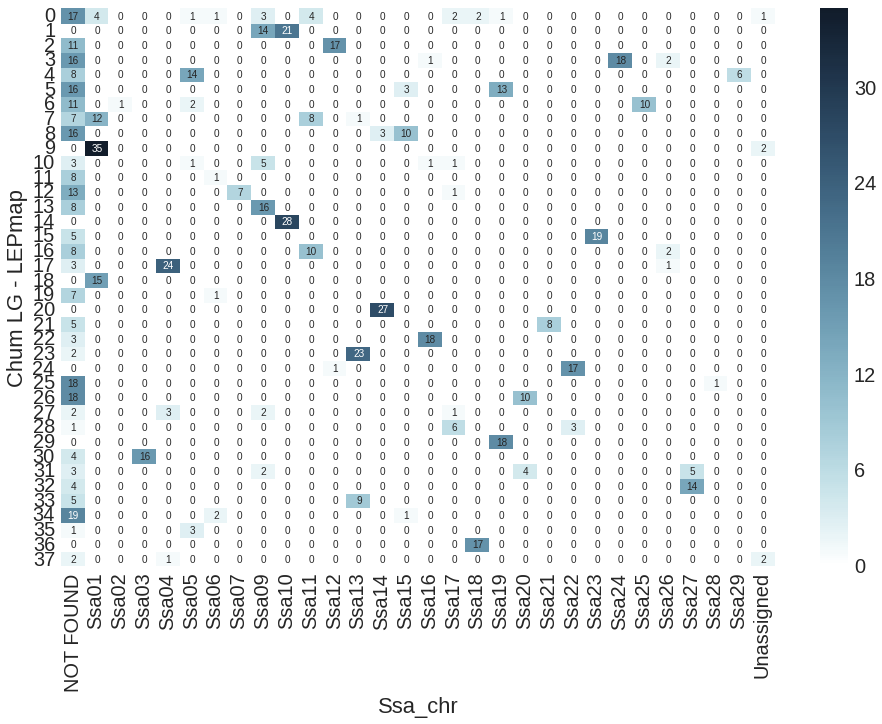

In [182]:
figsize(16,10)
my_colors = sns.cubehelix_palette(n_colors = 6, light=1, start = 2.8, rot = -.1, gamma = 1.2, as_cmap=True)
sns.heatmap(LG_vs_CHR, annot = True, linewidths = 0,square = False, cmap=my_colors, 
           cbar_kws={"orientation": "vertical"})
plt.show()

In [210]:
chum_ssa.to_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/chum_ssa.txt',sep = '\t')


In [184]:
chum_ssa.groupby('LEP_LG')['Ssa_chr'].count()

LEP_LG
0     36
1     35
2     28
3     37
4     28
5     32
6     24
7     28
8     29
9     37
10    11
11     9
12    21
13    24
14    28
15    24
16    20
17    28
18    15
19     8
20    27
21    13
22    21
23    25
24    18
25    19
26    28
27     8
28    10
29    18
30    20
31    14
32    18
33    14
34    22
35     4
36    17
37     5
Name: Ssa_chr, dtype: int64

In [185]:
chum_ssa.groupby('Ssa_chr')['LEP_LG'].count()

Ssa_chr
NOT FOUND     244
Ssa01          66
Ssa02           1
Ssa03          16
Ssa04          28
Ssa05          21
Ssa06           5
Ssa07           7
Ssa09          42
Ssa10          49
Ssa11          22
Ssa12          18
Ssa13          33
Ssa14          30
Ssa15          14
Ssa16          20
Ssa17          11
Ssa18          19
Ssa19          32
Ssa20          14
Ssa21           8
Ssa22          20
Ssa23          19
Ssa24          18
Ssa25          10
Ssa26           5
Ssa27          19
Ssa28           1
Ssa29           6
Unassigned      5
Name: LEP_LG, dtype: int64

#### Ssa chromosome assignments of the Ssa scaffolds that recieved at least one alignment

In [78]:
ssa_cov.groupby('Ssa_chr')['contig'].nunique()

Ssa_chr
NOT FOUND     84
Ssa01         16
Ssa02          2
Ssa03          6
Ssa04          7
Ssa05          8
Ssa06          3
Ssa07          2
Ssa08          4
Ssa09         16
Ssa10          9
Ssa11          7
Ssa12          5
Ssa13         10
Ssa14          7
Ssa15          8
Ssa16          4
Ssa17          6
Ssa18          4
Ssa19          7
Ssa20          7
Ssa21          3
Ssa22          6
Ssa23          4
Ssa24          3
Ssa25          4
Ssa26          3
Ssa27          5
Ssa28          2
Ssa29          2
Unassigned     3
Name: contig, dtype: int64

#### Number of RAD loci aligning to scaffolds placed on each chromosome

In [84]:
ssa_cov.groupby('Ssa_chr')['COV'].sum()

Ssa_chr
NOT FOUND     2959
Ssa01          730
Ssa02            7
Ssa03          246
Ssa04          365
Ssa05          307
Ssa06          139
Ssa07           42
Ssa08           26
Ssa09          589
Ssa10          703
Ssa11          245
Ssa12          242
Ssa13          525
Ssa14          257
Ssa15          201
Ssa16          271
Ssa17           88
Ssa18          240
Ssa19          326
Ssa20          206
Ssa21           89
Ssa22          300
Ssa23          209
Ssa24          197
Ssa25          268
Ssa26           78
Ssa27          116
Ssa28           53
Ssa29           45
Unassigned      23
Name: COV, dtype: int64

#### As expected, larger genome scaffolds have more RAD loci aligned to them

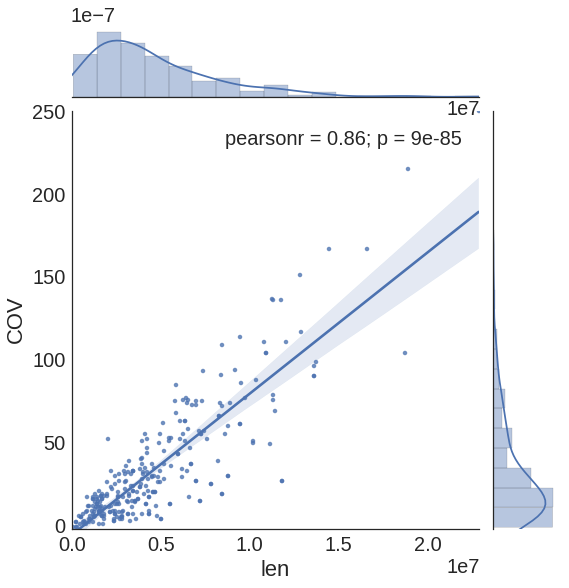

In [191]:
sns.jointplot('len', 'COV', data = ssa_cov,  kind = 'reg', size = 8, 
              xlim =(-1, max(ssa_cov['len'])), ylim=(-1, max(ssa_cov['COV'])))
plt.show()